# Análise Comparativa: Ibovespa vs CDI

## Vale a Pena Assumir o Risco de Investir em Ações no Brasil?

Este notebook compara a performance das 5 ações mais líquidas do Ibovespa com o CDI (Certificado de Depósito Interbancário), que é considerado a **taxa livre de risco** no Brasil.

### Objetivo

Responder à pergunta fundamental de todo investidor brasileiro:
- **Vale a pena assumir o risco de investir em ações quando posso ter retorno "garantido" com CDI?**
- **Qual o prêmio de risco que as ações oferecem sobre o CDI?**
- **Com que frequência as ações superam o CDI?**

### Ações Analisadas
- **PETR4** - Petrobras
- **VALE3** - Vale
- **ITUB4** - Itaú Unibanco
- **BBDC4** - Bradesco
- **ABEV3** - Ambev

### O que é o CDI?

O **CDI (Certificado de Depósito Interbancário)** é a taxa de juros que os bancos usam para emprestar dinheiro entre si. Na prática:
- É usado como **benchmark** para investimentos de renda fixa
- Representa o **retorno livre de risco** no Brasil
- CDBs, LCIs, LCAs geralmente pagam um percentual do CDI (ex: 100% do CDI)
- Acompanha de perto a taxa SELIC (taxa básica de juros)

---

## 1. Importações e Configurações

In [52]:
import sys
import os

# Adicionar src ao caminho
sys.path.insert(0, os.path.join(os.getcwd(), '..')) # Add project root to path

from src.data.di_loader import load_di_data

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
pd.options.display.float_format = '{:.4f}'.format

%matplotlib inline

print("Importações realizadas com sucesso!")

Importações realizadas com sucesso!


## 2. Download de Dados

### 2.1 Dados das Ações

In [53]:
# Definir período de análise (5 anos)
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print(f"Período de análise: {start_date.strftime('%Y-%m-%d')} até {end_date.strftime('%Y-%m-%d')}")
print(f"Aproximadamente {(end_date - start_date).days} dias de dados\n")

# Tickers das ações
tickers = ['PETR4.SA', 'VALE3.SA', 'ITUB4.SA', 'BBDC4.SA', 'ABEV3.SA']

print("Baixando dados das ações...")
# Baixar dados completos
raw_data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# Tentar pegar Adj Close, se não, pegar Close
if 'Adj Close' in raw_data.columns:
    stocks_data = raw_data['Adj Close']
elif 'Close' in raw_data.columns:
    stocks_data = raw_data['Close']
else:
    # Se for MultiIndex e não tiver nível superior explícito fácil
    # Geralmente yfinance retorna MultiIndex (Preço, Ticker) ou (Ticker, Preço)
    # Vamos tentar inferir
    try:
        stocks_data = raw_data.xs('Adj Close', axis=1, level=0)
    except KeyError:
        stocks_data = raw_data.xs('Close', axis=1, level=0)

# Garantir que só temos as colunas dos tickers
stocks_data = stocks_data[tickers]

# Renomear colunas
stocks_data.columns = [ticker.replace('.SA', '') for ticker in stocks_data.columns]

print(f"Baixados {len(stocks_data)} dias de dados para {len(tickers)} ações\n")
display(stocks_data.head())
display(stocks_data.tail())

Período de análise: 2020-12-08 até 2025-12-07
Aproximadamente 1825 dias de dados

Baixando dados das ações...
Baixados 1246 dias de dados para 5 ações



,PETR4,VALE3,ITUB4,BBDC4,ABEV3
Date,,,,,
2020-12-08,7.8979,50.4204,21.1765,15.0363,11.5571
2020-12-09,7.9808,50.2988,21.3021,15.0773,11.7183
2020-12-10,8.2415,51.6977,22.0066,15.6985,12.0485
2020-12-11,8.1674,51.6125,21.8765,15.5754,11.9026
2020-12-14,8.1822,50.8158,21.5830,15.4934,11.7644


,PETR4,VALE3,ITUB4,BBDC4,ABEV3
Date,,,,,
2025-12-01,31.8500,67.9200,41.2823,19.3310,14.0100
2025-12-02,32.0700,68.4800,42.2200,19.5400,14.0000
2025-12-03,32.3100,70.6900,42.2200,19.0000,14.1500
2025-12-04,32.5200,71.9200,43.2600,19.2700,13.9500
2025-12-05,31.3700,70.2200,41.2600,18.1200,13.6100


### 2.2 Dados do CDI

**Estratégia:** Vamos tentar obter dados do CDI de diferentes fontes:
1. Primeiro tentaremos via yfinance (usando proxy SELIC)
2. Se não funcionar, usaremos API do Banco Central
3. Como fallback, usaremos dados históricos estimados

In [54]:
# Carregar dados do CDI do arquivo local usando o módulo src.data.di_loader
try:
    # Caminho relativo para o arquivo de dados
    di_path = '../data/DI_PRE_OVER_5y.xls'
    
    print(f"Carregando dados do CDI de {di_path}...")
    di_data = load_di_data(di_path)
    
    # Extrair série de taxas diárias para compatibilidade
    if di_data is not None:
        cdi_returns = di_data['di_daily_rate']
        
        # Filtrar para o período de análise
        if 'start_date' in locals() and 'end_date' in locals():
            cdi_returns = cdi_returns[start_date:end_date]
        
        print(f"Dados do CDI carregados com sucesso")
        if not cdi_returns.empty:
            print(f"Período: {cdi_returns.index.min().date()} até {cdi_returns.index.max().date()}")
            
            print(f"\nEstatísticas do CDI:")
            print(f"Taxa diária média: {cdi_returns.mean()*100:.4f}%")
            print(f"Taxa anual equivalente: {((1 + cdi_returns.mean())**252 - 1)*100:.2f}%")
        else:
             print("Aviso: Nenhum dado encontrado para o período selecionado.")
    else:
        print("Falha ao carregar dados do CDI. Verifique se o arquivo existe.")
        raise ValueError("Dados do CDI não encontrados")
        
except Exception as e:
    print(f"Erro ao carregar dados do CDI: {e}")


Carregando dados do CDI de ../data/DI_PRE_OVER_5y.xls...
Dados do CDI carregados com sucesso
Período: 2020-12-09 até 2025-12-04

Estatísticas do CDI:
Taxa diária média: 0.0408%
Taxa anual equivalente: 10.82%


### 2.3 Alinhamento de Datas

Precisamos garantir que as ações e o CDI tenham as mesmas datas para comparação justa.

In [55]:
# Alinhar datas entre ações e CDI
common_dates = stocks_data.index.intersection(cdi_returns.index)

stocks_data_aligned = stocks_data.loc[common_dates]
cdi_returns_aligned = cdi_returns.loc[common_dates]

print(f"Datas alinhadas: {len(common_dates)} dias úteis")
print(f"Período: {common_dates[0].strftime('%Y-%m-%d')} até {common_dates[-1].strftime('%Y-%m-%d')}")

Datas alinhadas: 1244 dias úteis
Período: 2020-12-09 até 2025-12-04


## 3. Cálculo de Retornos

Vamos calcular os retornos diários das ações e compará-los com o CDI.

In [56]:
# Calcular retornos diários das ações
stock_returns = stocks_data_aligned.pct_change().dropna()

# Alinhar CDI com retornos das ações
cdi_returns_final = cdi_returns_aligned.loc[stock_returns.index]

# Adicionar CDI ao DataFrame de retornos
all_returns = stock_returns.copy()
all_returns['CDI'] = cdi_returns_final

print("Retornos calculados")
print(f"\nEstatísticas dos Retornos Diários (%):\n")
display(all_returns.describe() * 100)

Retornos calculados

Estatísticas dos Retornos Diários (%):



,PETR4,VALE3,ITUB4,BBDC4,ABEV3,CDI
count,124300.0000,124300.0000,124300.0000,124300.0000,124300.0000,124300.0000
mean,0.1364,0.0464,0.0701,0.0378,0.0252,0.0409
std,2.1475,1.8855,1.6069,1.8916,1.4979,0.0139
min,-20.7099,-7.5913,-17.9643,-17.3843,-6.4684,0.0075
25%,-0.8658,-1.0503,-0.8297,-0.9068,-0.7910,0.0393
50%,0.1043,-0.0351,0.0320,0.0000,0.0000,0.0455
75%,1.2778,1.0033,0.9955,1.0093,0.7817,0.0508
max,11.0291,10.3957,8.2688,15.6442,9.7240,0.0551


## 4. Performance Acumulada: R$ 100 Investidos

Vamos simular quanto R$ 100 investidos em cada ativo valeriam hoje.

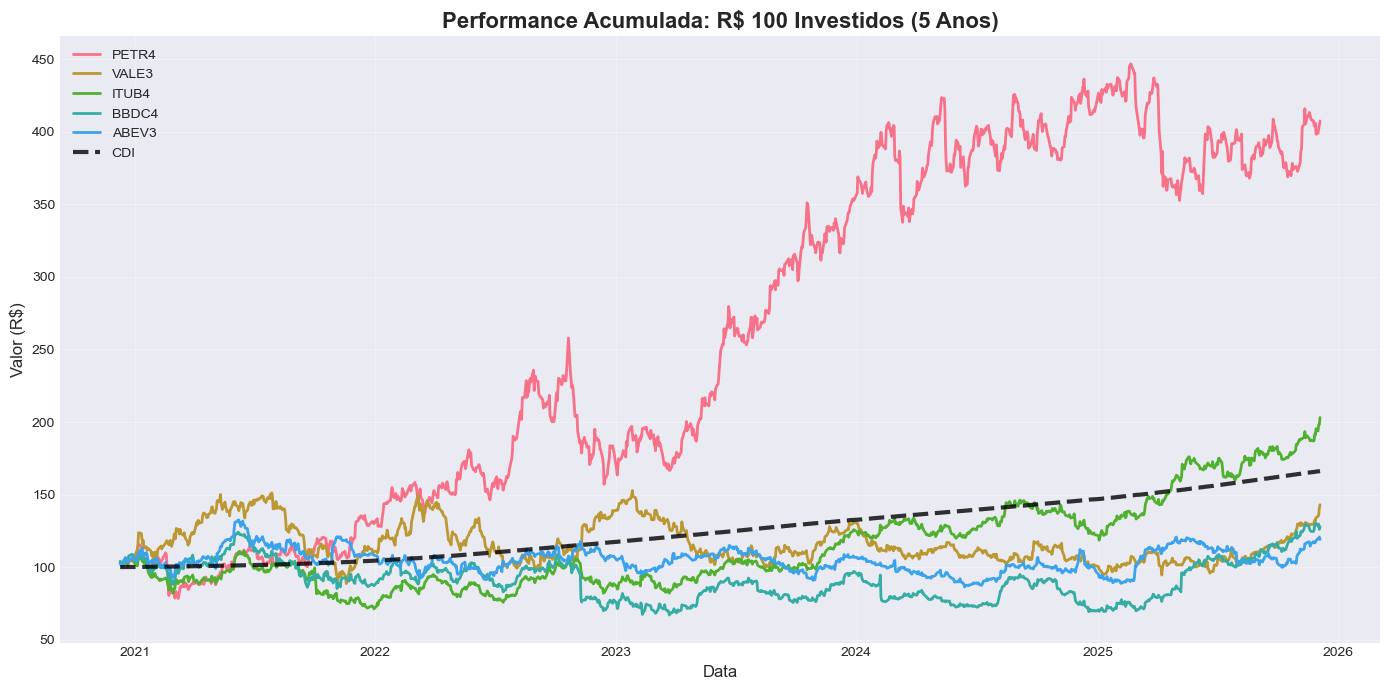


Valor Final de R$ 100 Investidos:

 PETR4 : R$  407.48 (Lucro: R$ 307.48 | +307.48%)
 ITUB4 : R$  203.08 (Lucro: R$ 103.08 | +103.08%)
 CDI   : R$  166.20 (Lucro: R$  66.20 | +66.20%)
 VALE3 : R$  142.99 (Lucro: R$  42.99 | +42.99%)
 BBDC4 : R$  127.81 (Lucro: R$  27.81 | +27.81%)
 ABEV3 : R$  119.04 (Lucro: R$  19.04 | +19.04%)


In [58]:
# Calcular retorno acumulado (começando com R$ 100)
cumulative_returns = (1 + all_returns).cumprod() * 100

# Visualizar performance acumulada
plt.figure(figsize=(14, 7))
for column in cumulative_returns.columns:
    if column == 'CDI':
        plt.plot(cumulative_returns.index, cumulative_returns[column], 
                label=column, linewidth=3, linestyle='--', color='black', alpha=0.8)
    else:
        plt.plot(cumulative_returns.index, cumulative_returns[column], label=column, linewidth=2)

plt.title('Performance Acumulada: R$ 100 Investidos (5 Anos)', fontsize=16, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Valor (R$)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Mostrar valores finais
print("\nValor Final de R$ 100 Investidos:\n")
final_values = cumulative_returns.iloc[-1].sort_values(ascending=False)
for asset, value in final_values.items():
    profit = value - 100
    profit_pct = (value / 100 - 1) * 100
    symbol = "📈" if value > final_values['CDI'] else "📉"
    print(f"{symbol} {asset:6s}: R$ {value:7.2f} (Lucro: R$ {profit:6.2f} | {profit_pct:+6.2f}%)")

## 5. Métricas de Risco e Retorno

Vamos calcular as principais métricas para avaliar se o risco das ações compensa.

In [59]:
def calculate_metrics(returns, risk_free_rate):
    """
    Calcula métricas de risco e retorno.
    
    Parameters:
    -----------
    returns : pd.Series
        Série de retornos diários
    risk_free_rate : pd.Series
        Taxa livre de risco (CDI) diária
    
    Returns:
    --------
    dict : Dicionário com as métricas calculadas
    """
    # Retorno anualizado
    annual_return = (1 + returns.mean()) ** 252 - 1
    
    # Volatilidade anualizada
    annual_vol = returns.std() * np.sqrt(252)
    
    # Retorno acumulado total
    total_return = (1 + returns).prod() - 1
    
    # Sharpe Ratio (usando CDI como risk-free)
    excess_returns = returns - risk_free_rate
    sharpe = (excess_returns.mean() / excess_returns.std()) * np.sqrt(252) if excess_returns.std() > 0 else 0
    
    # Sortino Ratio (considera apenas volatilidade negativa)
    downside_returns = excess_returns[excess_returns < 0]
    downside_std = downside_returns.std() * np.sqrt(252)
    sortino = (annual_return - risk_free_rate.mean() * 252) / downside_std if downside_std > 0 else 0
    
    # Maximum Drawdown
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.expanding().max()
    drawdown = (cum_returns - running_max) / running_max
    max_dd = drawdown.min()
    
    # Calmar Ratio (Retorno / Max Drawdown)
    calmar = annual_return / abs(max_dd) if max_dd != 0 else 0
    
    return {
        'Retorno Anual': annual_return,
        'Retorno Total': total_return,
        'Volatilidade Anual': annual_vol,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Max Drawdown': max_dd,
        'Calmar Ratio': calmar
    }

# Calcular métricas para cada ativo
metrics_dict = {}
for column in all_returns.columns:
    if column == 'CDI':
        # Para CDI, usar ele mesmo como risk-free (Sharpe = 0 por definição)
        metrics_dict[column] = calculate_metrics(all_returns[column], all_returns[column])
    else:
        metrics_dict[column] = calculate_metrics(all_returns[column], all_returns['CDI'])

# Criar DataFrame com métricas
metrics_df = pd.DataFrame(metrics_dict).T

print("Métricas de Risco e Retorno:\n")
display(metrics_df.style.format({
    'Retorno Anual': '{:.2%}',
    'Retorno Total': '{:.2%}',
    'Volatilidade Anual': '{:.2%}',
    'Sharpe Ratio': '{:.3f}',
    'Sortino Ratio': '{:.3f}',
    'Max Drawdown': '{:.2%}',
    'Calmar Ratio': '{:.3f}'
}))

Métricas de Risco e Retorno:



,Retorno Anual,Retorno Total,Volatilidade Anual,Sharpe Ratio,Sortino Ratio,Max Drawdown,Calmar Ratio
PETR4,41.00%,307.48%,34.09%,0.706,1.152,-39.10%,1.049
VALE3,12.41%,42.99%,29.93%,0.047,0.115,-41.34%,0.300
ITUB4,19.30%,103.08%,25.51%,0.288,0.490,-35.87%,0.538
BBDC4,10.00%,27.81%,30.03%,-0.026,-0.014,-46.04%,0.217
ABEV3,6.55%,19.04%,23.78%,-0.166,-0.244,-34.88%,0.188
CDI,10.85%,66.20%,0.22%,0.000,0.000,0.00%,0.000


### 5.1 Interpretação das Métricas

**Sharpe Ratio:**
- Mede o retorno excedente por unidade de risco
- Sharpe > 1: Bom
- Sharpe > 2: Muito bom
- Sharpe > 3: Excelente

**Sortino Ratio:**
- Similar ao Sharpe, mas considera apenas volatilidade negativa
- Mais relevante para investidores avessos a perdas

**Calmar Ratio:**
- Retorno anual dividido pelo máximo drawdown
- Quanto maior, melhor a relação retorno/risco de queda

## 6. Análise de Excesso de Retorno

Quanto as ações retornaram **acima** do CDI?

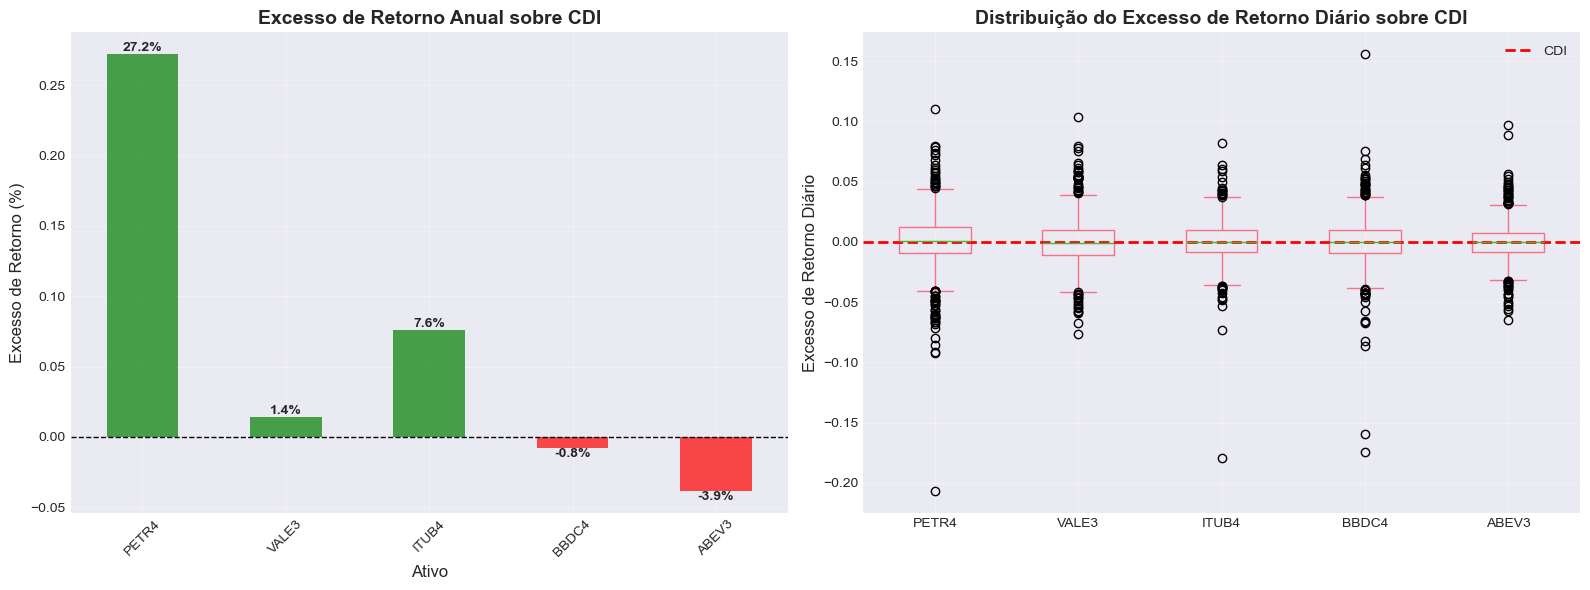


Excesso de Retorno Anual sobre CDI:

✅ PETR4 :  +27.21% ao ano
✅ ITUB4 :   +7.63% ao ano
✅ VALE3 :   +1.41% ao ano
❌ BBDC4 :   -0.77% ao ano
❌ ABEV3 :   -3.88% ao ano


In [60]:
# Calcular excesso de retorno sobre CDI
excess_returns = all_returns.drop('CDI', axis=1).sub(all_returns['CDI'], axis=0)

# Retorno excedente anualizado
annual_excess = (1 + excess_returns.mean()) ** 252 - 1

# Visualizar excesso de retorno
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Excesso de retorno anualizado
colors = ['green' if x > 0 else 'red' for x in annual_excess]
annual_excess.plot(kind='bar', ax=ax1, color=colors, alpha=0.7)
ax1.set_title('Excesso de Retorno Anual sobre CDI', fontsize=14, fontweight='bold')
ax1.set_xlabel('Ativo', fontsize=12)
ax1.set_ylabel('Excesso de Retorno (%)', fontsize=12)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax1.grid(True, alpha=0.3)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Adicionar valores nas barras
for i, v in enumerate(annual_excess):
    ax1.text(i, v, f'{v*100:.1f}%', ha='center', va='bottom' if v > 0 else 'top', fontweight='bold')

# Gráfico 2: Distribuição do excesso de retorno diário
excess_returns.plot(kind='box', ax=ax2)
ax2.set_title('Distribuição do Excesso de Retorno Diário sobre CDI', fontsize=14, fontweight='bold')
ax2.set_ylabel('Excesso de Retorno Diário', fontsize=12)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=2, label='CDI')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

print("\nExcesso de Retorno Anual sobre CDI:\n")
for asset, excess in annual_excess.sort_values(ascending=False).items():
    symbol = "✅" if excess > 0 else "❌"
    print(f"{symbol} {asset:6s}: {excess*100:+7.2f}% ao ano")

## 7. Consistência: % de Períodos Batendo o CDI

Com que frequência cada ação superou o CDI?

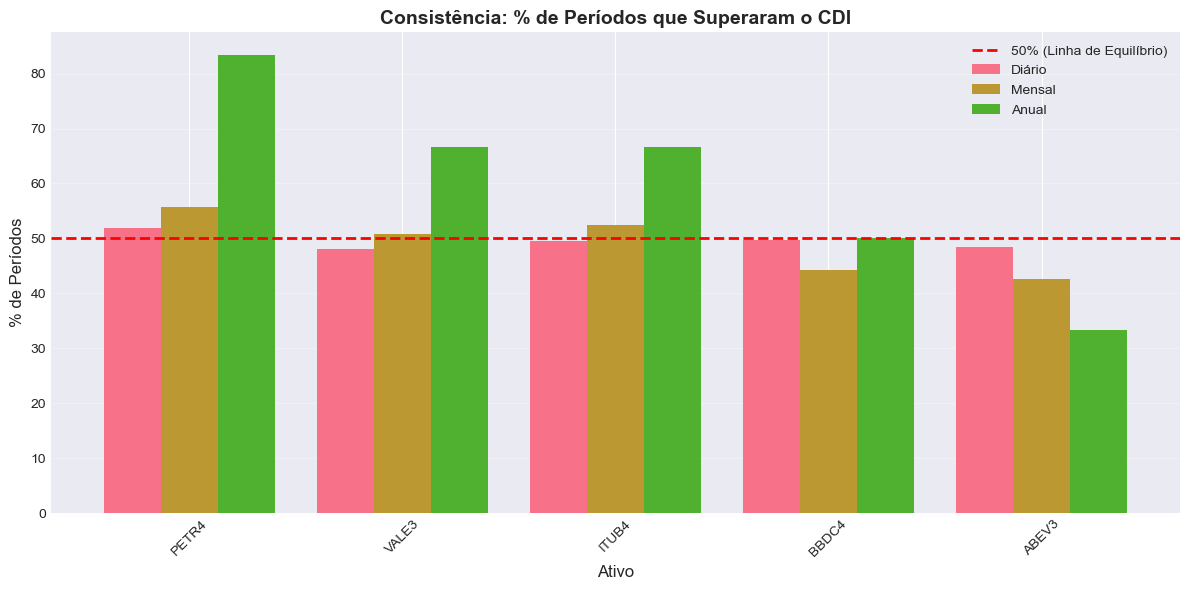


📊 Consistência em Superar o CDI (%):



,Diário,Mensal,Anual
PETR4,52.0%,55.7%,83.3%
VALE3,48.0%,50.8%,66.7%
ITUB4,49.5%,52.5%,66.7%
BBDC4,49.8%,44.3%,50.0%
ABEV3,48.4%,42.6%,33.3%


In [61]:
# Calcular % de dias que bateram CDI
beat_cdi_daily = (all_returns.drop('CDI', axis=1) > all_returns['CDI'].values.reshape(-1, 1)).mean() * 100

# Calcular retornos mensais
monthly_returns = all_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
beat_cdi_monthly = (monthly_returns.drop('CDI', axis=1) > monthly_returns['CDI'].values.reshape(-1, 1)).mean() * 100

# Calcular retornos anuais
yearly_returns = all_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1)
beat_cdi_yearly = (yearly_returns.drop('CDI', axis=1) > yearly_returns['CDI'].values.reshape(-1, 1)).mean() * 100

# Criar DataFrame de consistência
consistency_df = pd.DataFrame({
    'Diário': beat_cdi_daily,
    'Mensal': beat_cdi_monthly,
    'Anual': beat_cdi_yearly
})

# Visualizar
fig, ax = plt.subplots(figsize=(12, 6))
consistency_df.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Consistência: % de Períodos que Superaram o CDI', fontsize=14, fontweight='bold')
ax.set_xlabel('Ativo', fontsize=12)
ax.set_ylabel('% de Períodos', fontsize=12)
ax.axhline(y=50, color='red', linestyle='--', linewidth=2, label='50% (Linha de Equilíbrio)')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

print("\n📊 Consistência em Superar o CDI (%):\n")
display(consistency_df.style.format('{:.1f}%'))

## 8. Análise de Risco vs Retorno

Visualização clássica: quanto mais retorno, mais risco?

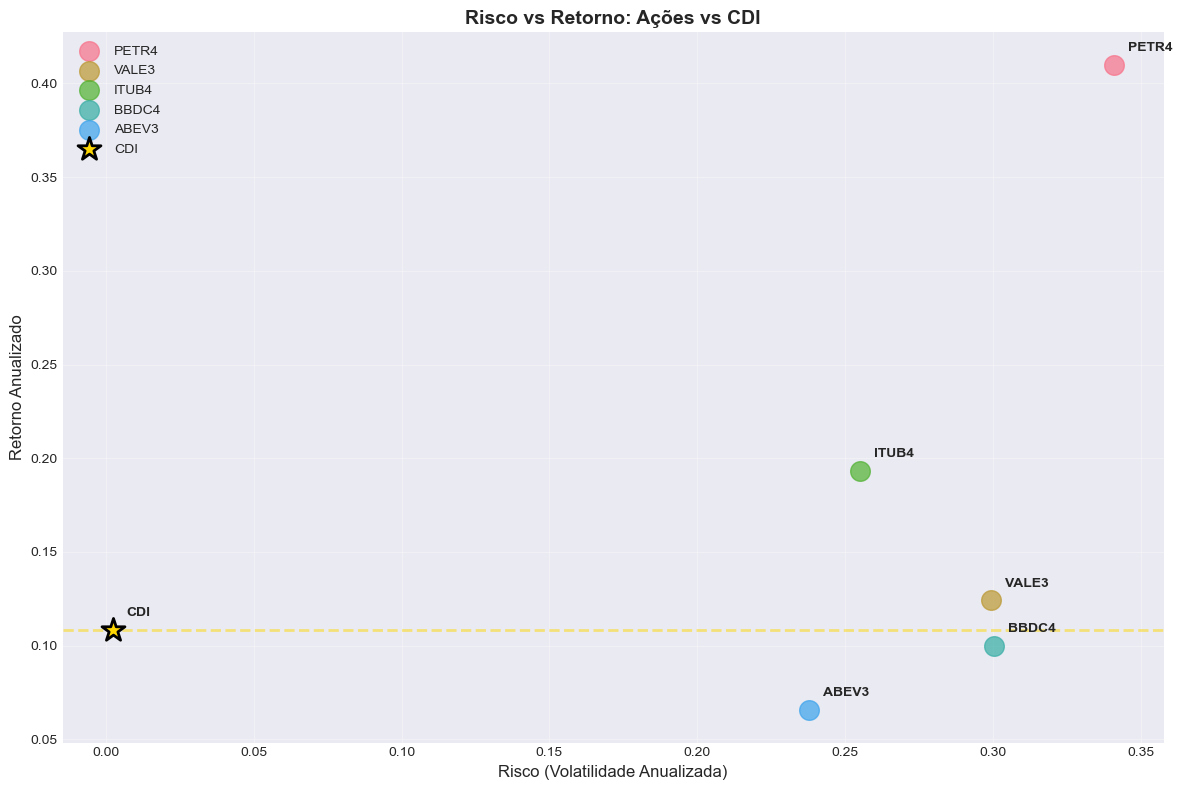

In [62]:
# Criar scatter plot de Risco vs Retorno
plt.figure(figsize=(12, 8))

for asset in metrics_df.index:
    x = metrics_df.loc[asset, 'Volatilidade Anual']
    y = metrics_df.loc[asset, 'Retorno Anual']
    
    if asset == 'CDI':
        plt.scatter(x, y, s=300, marker='*', c='gold', edgecolors='black', linewidths=2, 
                   label=asset, zorder=5)
    else:
        plt.scatter(x, y, s=200, alpha=0.7, label=asset)
    
    # Adicionar rótulos
    plt.annotate(asset, (x, y), xytext=(10, 10), textcoords='offset points', 
                fontsize=10, fontweight='bold')

plt.xlabel('Risco (Volatilidade Anualizada)', fontsize=12)
plt.ylabel('Retorno Anualizado', fontsize=12)
plt.title('Risco vs Retorno: Ações vs CDI', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(loc='best')

# Adicionar linha do CDI
cdi_return = metrics_df.loc['CDI', 'Retorno Anual']
plt.axhline(y=cdi_return, color='gold', linestyle='--', linewidth=2, alpha=0.5, label='Retorno CDI')

plt.tight_layout()
plt.show()

## 9. Comparação de Sharpe Ratio

O Sharpe Ratio ajustado ao CDI mostra qual ação oferece melhor retorno por unidade de risco.

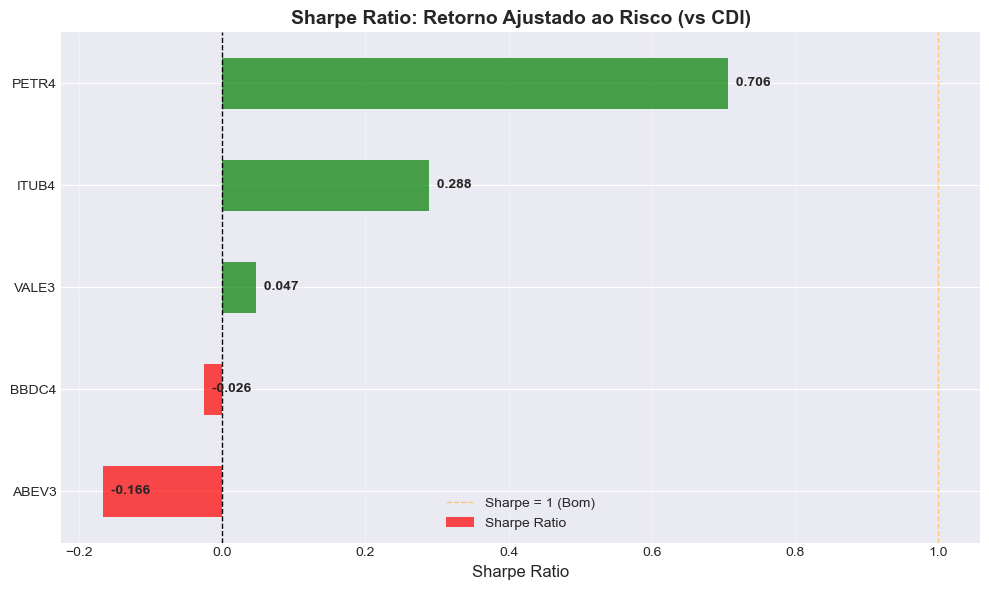


Interpretação do Sharpe Ratio:

PETR4 :  0.706 - ⭐ Bom
ITUB4 :  0.288 - ⭐ Bom
VALE3 :  0.047 - ⭐ Bom
BBDC4 : -0.026 - ❌ Ruim (não compensa o risco)
ABEV3 : -0.166 - ❌ Ruim (não compensa o risco)


In [64]:
# Visualizar Sharpe Ratio
sharpe_sorted = metrics_df['Sharpe Ratio'].drop('CDI').sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in sharpe_sorted]
sharpe_sorted.plot(kind='barh', ax=ax, color=colors, alpha=0.7)

ax.set_title('Sharpe Ratio: Retorno Ajustado ao Risco (vs CDI)', fontsize=14, fontweight='bold')
ax.set_xlabel('Sharpe Ratio', fontsize=12)
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.axvline(x=1, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Sharpe = 1 (Bom)')
ax.grid(True, alpha=0.3, axis='x')
ax.legend()

# Adicionar valores nas barras
for i, v in enumerate(sharpe_sorted):
    ax.text(v, i, f'  {v:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nInterpretação do Sharpe Ratio:\n")
for asset, sharpe in sharpe_sorted.sort_values(ascending=False).items():
    if sharpe > 2:
        rating = "⭐⭐⭐ Excelente"
    elif sharpe > 1:
        rating = "⭐⭐ Muito Bom"
    elif sharpe > 0:
        rating = "⭐ Bom"
    else:
        rating = "❌ Ruim (não compensa o risco)"
    
    print(f"{asset:6s}: {sharpe:6.3f} - {rating}")

## 10. Drawdown Comparison

Qual foi a maior queda de cada ativo? CDI não tem drawdown (é livre de risco).

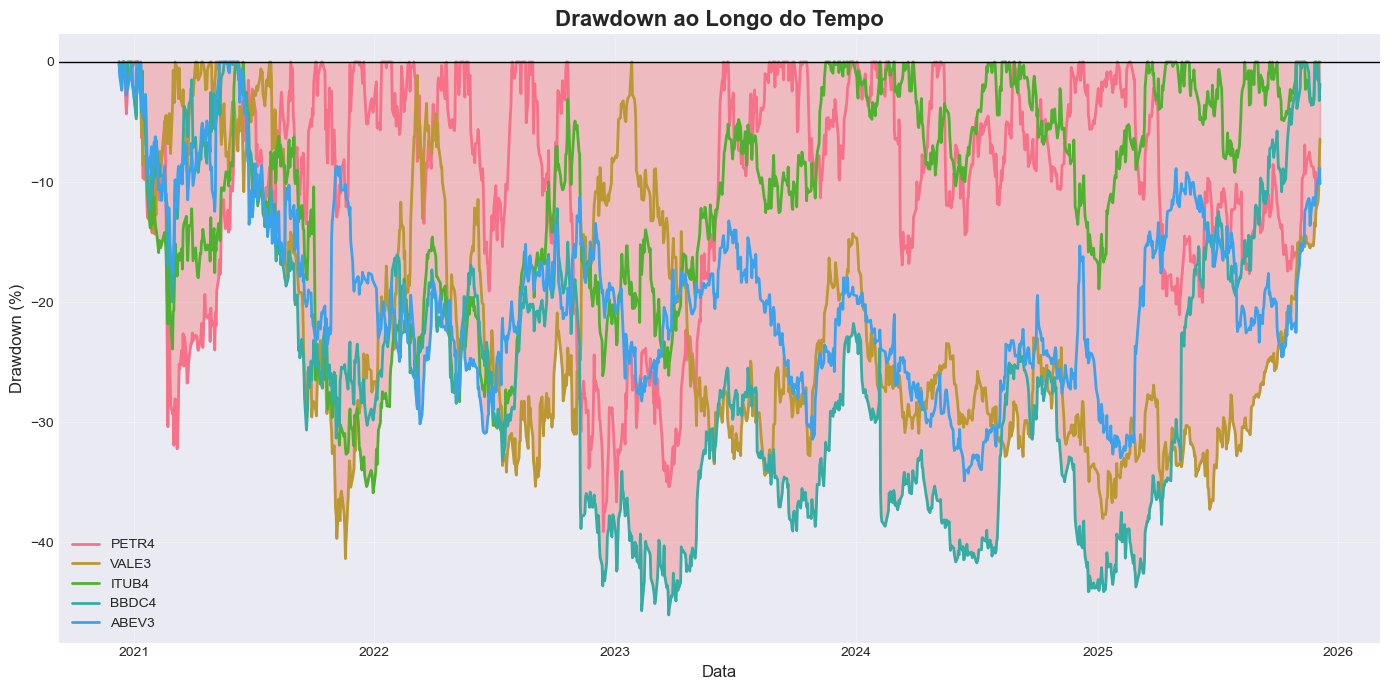


Máximo Drawdown (Maior Queda do Pico):

BBDC4 :  -46.04%
VALE3 :  -41.34%
PETR4 :  -39.10%
ITUB4 :  -35.87%
ABEV3 :  -34.88%

CDI: 0.00% (sem drawdown - risco zero)


In [65]:
# Calcular drawdowns
def calculate_drawdown(returns):
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.expanding().max()
    drawdown = (cum_returns - running_max) / running_max
    return drawdown

# Calcular para cada ativo
drawdowns = pd.DataFrame()
for column in all_returns.columns:
    if column != 'CDI':  # CDI não tem drawdown
        drawdowns[column] = calculate_drawdown(all_returns[column])

# Visualizar
plt.figure(figsize=(14, 7))
for column in drawdowns.columns:
    plt.plot(drawdowns.index, drawdowns[column] * 100, label=column, linewidth=2)

plt.fill_between(drawdowns.index, 0, drawdowns.min(axis=1) * 100, alpha=0.2, color='red')
plt.title('Drawdown ao Longo do Tempo', fontsize=16, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Drawdown (%)', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.tight_layout()
plt.show()

# Mostrar máximo drawdown
print("\nMáximo Drawdown (Maior Queda do Pico):\n")
max_dd = drawdowns.min().sort_values()
for asset, dd in max_dd.items():
    print(f"{asset:6s}: {dd*100:7.2f}%")

print(f"\nCDI: 0.00% (sem drawdown - risco zero)")

## 11. Conclusões e Recomendações

### Vale a Pena Investir em Ações no Brasil?

Vamos analisar os resultados:

In [68]:
# Criar resumo executivo
print("="*80)
print("RESUMO EXECUTIVO: AÇÕES vs CDI")
print("="*80)

# 1. Retorno
print("\nRETORNO TOTAL (5 anos):\n")
total_returns = metrics_df['Retorno Total'].sort_values(ascending=False)
for asset, ret in total_returns.items():
    symbol = "📈" if ret > total_returns['CDI'] else "📉" if asset != 'CDI' else "💰"
    print(f"   {symbol} {asset:6s}: {ret*100:7.2f}%")

# 2. Risco (Volatilidade)
print("\nRISCO (Volatilidade Anual):\n")
vols = metrics_df['Volatilidade Anual'].sort_values()
for asset, vol in vols.items():
    print(f"   {asset:6s}: {vol*100:7.2f}%")

# 3. Sharpe Ratio
print("\nSHARPE RATIO (Retorno Ajustado ao Risco):\n")
sharpes = metrics_df['Sharpe Ratio'].drop('CDI').sort_values(ascending=False)
for asset, sharpe in sharpes.items():
    print(f"   {asset:6s}: {sharpe:6.3f}")

# 4. Consistência
print("\nCONSISTÊNCIA (% Meses Batendo CDI):\n")
for asset, pct in beat_cdi_monthly.sort_values(ascending=False).items():
    print(f"   {asset:6s}: {pct:5.1f}%")

# 5. Drawdown
print("\nMÁXIMO DRAWDOWN (Maior Queda):\n")
for asset, dd in metrics_df['Max Drawdown'].drop('CDI').sort_values().items():
    print(f"   {asset:6s}: {dd*100:7.2f}%")
print(f"   CDI   :    0.00% (sem risco)")

print("\n" + "="*80)
print("CONCLUSÃO")
print("="*80)

# Análise automática
avg_sharpe = sharpes.mean()
avg_beat_monthly = beat_cdi_monthly.mean()
best_stock = sharpes.idxmax()
worst_stock = sharpes.idxmin()

print(f"""
VALE A PENA? {'SIM' if avg_sharpe > 0.5 else 'DEPENDE' if avg_sharpe > 0 else 'NÃO'}

Análise:
   • Sharpe Ratio médio: {avg_sharpe:.3f}
   • Melhor ação: {best_stock} (Sharpe: {sharpes[best_stock]:.3f})
   • Pior ação: {worst_stock} (Sharpe: {sharpes[worst_stock]:.3f})
   • Consistência média: {avg_beat_monthly:.1f}% dos meses batem CDI

Recomendações:

{'As ações analisadas apresentaram Sharpe Ratio positivo, indicando que o' if avg_sharpe > 0 else ' As ações não compensaram o risco assumido no período.'}
{'   retorno excedente compensou o risco assumido.' if avg_sharpe > 0 else ''}

{'Para investidores com horizonte de longo prazo (5+ anos), as ações' if avg_sharpe > 0.5 else '  Para investidores conservadores, o CDI pode ser mais adequado.'}
{'   podem ser uma boa opção de diversificação.' if avg_sharpe > 0.5 else ''}

{'Importante: Diversificação é fundamental! Não concentre todo o' if avg_sharpe > 0 else ' Considere uma carteira mista (ações + renda fixa) para equilibrar'}
{'   patrimônio em ações.' if avg_sharpe > 0 else '   risco e retorno.'}

Perfil de Investidor:
   • Conservador: 100% CDI ou 80% CDI + 20% Ações
   • Moderado: 50% CDI + 50% Ações
   • Arrojado: 20% CDI + 80% Ações
""")

RESUMO EXECUTIVO: AÇÕES vs CDI

RETORNO TOTAL (5 anos):

   📈 PETR4 :  307.48%
   📈 ITUB4 :  103.08%
   💰 CDI   :   66.20%
   📉 VALE3 :   42.99%
   📉 BBDC4 :   27.81%
   📉 ABEV3 :   19.04%

RISCO (Volatilidade Anual):

   CDI   :    0.22%
   ABEV3 :   23.78%
   ITUB4 :   25.51%
   VALE3 :   29.93%
   BBDC4 :   30.03%
   PETR4 :   34.09%

SHARPE RATIO (Retorno Ajustado ao Risco):

   PETR4 :  0.706
   ITUB4 :  0.288
   VALE3 :  0.047
   BBDC4 : -0.026
   ABEV3 : -0.166

CONSISTÊNCIA (% Meses Batendo CDI):

   PETR4 :  55.7%
   ITUB4 :  52.5%
   VALE3 :  50.8%
   BBDC4 :  44.3%
   ABEV3 :  42.6%

MÁXIMO DRAWDOWN (Maior Queda):

   BBDC4 :  -46.04%
   VALE3 :  -41.34%
   PETR4 :  -39.10%
   ITUB4 :  -35.87%
   ABEV3 :  -34.88%
   CDI   :    0.00% (sem risco)

CONCLUSÃO

VALE A PENA? DEPENDE

Análise:
   • Sharpe Ratio médio: 0.170
   • Melhor ação: PETR4 (Sharpe: 0.706)
   • Pior ação: ABEV3 (Sharpe: -0.166)
   • Consistência média: 49.2% dos meses batem CDI

Recomendações:

As ações anal

## 12. Próximos Passos

### Análises Adicionais Sugeridas:

1. **Otimização de Portfólio**
   - Encontrar a melhor combinação de ações + CDI
   - Fronteira eficiente
   
2. **Análise por Período**
   - Como as ações se comportaram em crises?
   - Análise de ciclos econômicos
   
3. **Análise Setorial**
   - Comparar setores (financeiro, commodities, consumo)
   
4. **Backtesting de Estratégias**
   - Rebalanceamento periódico
   - Dollar-cost averaging

---

### Referências:

- **CDI**: Certificado de Depósito Interbancário
- **Sharpe Ratio**: Desenvolvido por William F. Sharpe (Nobel de Economia 1990)
- **Dados**: Yahoo Finance e Banco Central do Brasil 

---

**Disclaimer:** Esta análise tem fins educacionais e não constitui recomendação de investimento. Consulte um profissional certificado antes de tomar decisões financeiras.